In [1]:
2370/3

790.0

In [2]:
790-332

458

In [3]:
790 - 486

304

In [4]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,LassoLars,SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer,mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
np.random.seed(25)
import os
import datetime
import warnings 
warnings.filterwarnings("ignore")

In [5]:
pd.read_csv('../input/sample_submission_dlc0jkw/sample_submission.csv').head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,8
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,8
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,8
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,8


In [6]:
train = pd.read_csv('../input/train_5clrc8b/train.csv')
test = pd.read_csv('../input/test_jwt0mqh/test.csv')

In [7]:
rids = test['reservation_id']
train.tail()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
341419,a804d59b74b1d532a90740ded80dd05873bbef125bc349...,11/02/19,27/02/19,01/03/19,2,2,4,0,47,1,1,2,4,4.0,8.0,1,2,I,1,0095e00c6dae789d37628bd85697e53c423231337994c4...,E,A,c6f3ac57944a531490cd39902d0f777715fd005efac9a3...,5.918087
341420,7062c92a631731e7189cf3dddb20aceeae91a883e14229...,27/02/19,28/02/19,01/03/19,2,4,2,0,45,1,5,3,1,4.0,10.0,1,2,D,1,42d7b97ad0d345da57a4010157729286418481f3d7ad24...,E,A,c75cb66ae28d8ebc6eded002c28a8ba0d06d3a78c6b5cb...,8.186771
341421,18a5668c302c321dc2d42a48923ceff97af633c66d72ee...,27/02/19,27/02/19,28/02/19,3,3,3,0,45,1,1,3,2,4.0,10.0,4,3,H,1,f393011a27daf3d1676417f48f44ad9ed3541285e71209...,F,A,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,8.381939
341422,1cbe1611a122023d7e994b4cf51fcf28ce44acdbcabbfb...,27/02/19,28/02/19,01/03/19,1,3,5,0,47,2,2,2,2,3.0,8.0,2,3,B,1,b14649c29eb050f4e9b69c7a3afb5dfa00d12dabfd2e40...,D,A,6208ef0f7750c111548cf90b6ea1d0d0a66f6bff40dbef...,8.856035
341423,8712dd3ce2e36f2fbcd16b24aa3b89bd1c5203a39e578b...,28/02/19,01/03/19,02/03/19,3,3,2,0,45,2,1,2,1,2.0,8.0,7,5,B,2,2a3936f649eb6af2167f41fb6f0cc9f352d142125f402f...,C,A,9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e47...,7.864627


In [8]:
train[train.room_type_booked_code == 6]

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
12477,31df53050c22383567ac31d520d3240caebc1b1479f4f9...,21/11/14,08/02/15,10/02/15,3,4,6,0,45,3,3,6,4,4.0,7.0,3,3,F,1,e2c28458bd0ca24472413c03601f752d1357dbc6ae21d1...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,5.053184
50127,000cd7d87df90b70775e465fdef094a747181756d7215f...,10/03/15,13/04/15,15/04/15,1,1,6,0,45,3,3,6,4,3.0,2.0,3,2,G,2,b9632f08773ef5f1249f3f914d8b41af8850b707882449...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,8.695870
58139,252b2f5636d22e0841f8b80a0948823bc2aef8b62f97c6...,02/02/15,21/05/15,23/05/15,3,1,2,0,45,3,3,6,2,1.0,8.0,3,4,D,1,dc2551acc70b57a3fa1924d9cb6b41ea6e56d880f7b976...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,9.197479
67528,be601c022844471a53c806b77136d3d0f5815c195fcf6f...,13/02/15,10/04/15,13/04/15,3,2,3,0,45,3,3,6,3,2.0,8.0,3,4,F,1,07cd80339440bb23f13945633f83f3460265d56d809274...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,8.218284
70140,f5d1553b08068a80079ad02a2f95432618b8d713faa6e0...,09/03/15,13/03/15,15/03/15,1,2,3,0,45,3,3,6,2,3.0,15.0,3,3,E,1,42cc0a9ef6c17d4c4a7cb7479be0e64ff8c311685fab1a...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,8.353227
80652,0462fc2109d6b1568e565320e6779b046483203503f993...,26/02/15,13/04/15,17/04/15,1,2,2,0,45,3,3,6,4,3.0,8.0,3,3,C,1,f9bc1a66fcef48d78da638d648455371b42159d52247a1...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.585850
89853,9ad2f75b2aad7c27f09457cac8e4949646fcfa14cfbd15...,18/03/15,18/03/15,19/03/15,3,3,3,0,45,3,3,6,1,3.0,9.0,3,4,E,1,ca981ffda10fa518e162dc376ac565c09b76b691879005...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,8.362941
95058,78a9f920ec12b93f23ff7d7b9a4180734a8eb199f76f56...,27/03/15,23/04/15,26/04/15,1,3,2,2,45,3,3,6,3,3.0,8.0,3,4,E,1,5545a07fe098387fb8267f7c2f25bcbb99f7b8669c59ee...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,8.044084
115462,99c9ddb46251585ebd39dcf968abdf59dc5b928bf8bfb0...,30/04/15,28/05/15,30/05/15,3,2,2,2,45,3,3,6,2,1.0,12.0,3,4,D,2,0449657819308126f47fa26d55ed1a58634c7114c625ce...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.445602
123283,2aa2b15975e0f4e7adcac51cc6317d521307c6c9482e39...,12/05/15,22/05/15,25/05/15,3,3,2,2,45,3,3,6,3,1.0,9.0,3,4,D,2,5b89dbcb3bc4a20afc8343eef4cb26a1a62d2a4d6dfda0...,F,A,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,8.006180


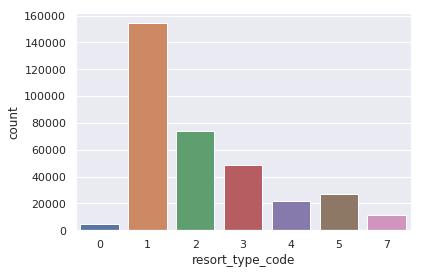

In [9]:
sns.countplot(train['resort_type_code'])

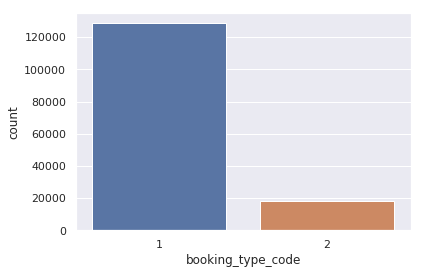

In [10]:
sns.countplot(test['booking_type_code'])

In [11]:
train.shape

(341424, 24)

In [12]:
train.isnull().sum()

reservation_id                           0
booking_date                             0
checkin_date                             0
checkout_date                            0
channel_code                             0
main_product_code                        0
numberofadults                           0
numberofchildren                         0
persontravellingid                       0
resort_region_code                       0
resort_type_code                         0
room_type_booked_code                    0
roomnights                               0
season_holidayed_code                  114
state_code_residence                  4764
state_code_resort                        0
total_pax                                0
member_age_buckets                       0
booking_type_code                        0
memberid                                 0
cluster_code                             0
reservationstatusid_code                 0
resort_id                                0
amount_spen

In [13]:
# impute null values
train['season_holidayed_code'].fillna(-999,inplace=True)
test['season_holidayed_code'].fillna(-999,inplace=True)

train['state_code_residence'].fillna(-999,inplace=True)
test['state_code_residence'].fillna(-999,inplace=True)

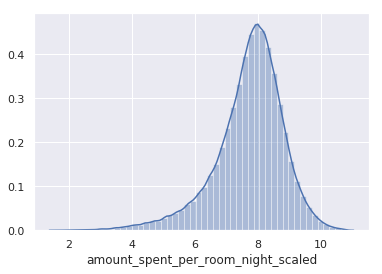

In [14]:
# target value distribution
sns.distplot(train['amount_spent_per_room_night_scaled'])

In [15]:
train.describe()

,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,booking_type_code,amount_spent_per_room_night_scaled
count,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000,341424.000000
mean,1.902810,2.208738,3.275361,0.362696,210.288905,1.772960,2.193832,2.890321,3.738346,2.339408,-6.779974,4.763303,3.193390,1.124209,7.720801
std,0.915311,0.823779,1.756062,0.758019,865.735577,0.750806,1.551451,0.804260,2.479054,18.321781,118.124006,3.103909,1.167824,0.329821,1.090109
min,1.000000,1.000000,0.000000,0.000000,45.000000,1.000000,0.000000,1.000000,-45.000000,-999.000000,-999.000000,1.000000,0.000000,1.000000,1.600397
25%,1.000000,2.000000,2.000000,0.000000,45.000000,1.000000,1.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,7.187260
50%,2.000000,2.000000,3.000000,0.000000,45.000000,2.000000,2.000000,3.000000,3.000000,3.000000,8.000000,5.000000,3.000000,1.000000,7.860814
75%,3.000000,3.000000,4.000000,0.000000,45.000000,2.000000,3.000000,3.000000,4.000000,3.000000,8.000000,7.000000,4.000000,1.000000,8.419144
max,3.000000,7.000000,32.000000,13.000000,4995.000000,3.000000,7.000000,6.000000,60.000000,4.000000,38.000000,13.000000,24.000000,2.000000,10.816652


In [16]:
sorted(train['state_code_resort'].unique())

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13]

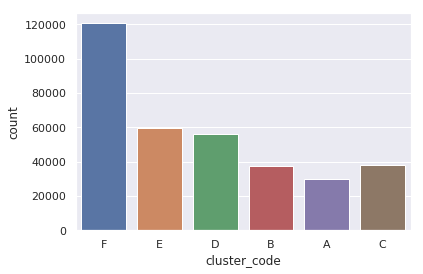

In [17]:
sns.countplot(train['cluster_code'])

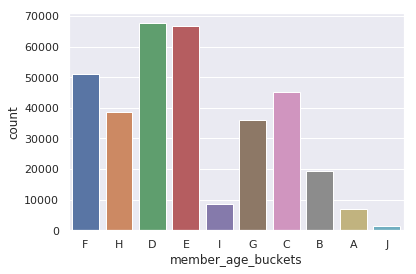

In [18]:
sns.countplot(train['member_age_buckets'])

# Feature Engineering

In [19]:
train.dtypes

reservation_id                         object
booking_date                           object
checkin_date                           object
checkout_date                          object
channel_code                            int64
main_product_code                       int64
numberofadults                          int64
numberofchildren                        int64
persontravellingid                      int64
resort_region_code                      int64
resort_type_code                        int64
room_type_booked_code                   int64
roomnights                              int64
season_holidayed_code                 float64
state_code_residence                  float64
state_code_resort                       int64
total_pax                               int64
member_age_buckets                     object
booking_type_code                       int64
memberid                               object
cluster_code                           object
reservationstatusid_code          

In [20]:
# # Handle Categorical features
# from sklearn.preprocessing import LabelEncoder

# lb_make = LabelEncoder()
# # train["member_age_buckets"] = lb_make.fit_transform(train["member_age_buckets"])
# # test["member_age_buckets"] = lb_make.fit_transform(test["member_age_buckets"])

# # train["cluster_code"] = lb_make.fit_transform(train["cluster_code"])
# # test["cluster_code"] = lb_make.fit_transform(test["cluster_code"])

# # train["reservationstatusid_code"] = lb_make.fit_transform(train["reservationstatusid_code"])
# # test["reservationstatusid_code"] = lb_make.fit_transform(test["reservationstatusid_code"])

# train["resort_id"] = lb_make.fit_transform(train["resort_id"])
# test["resort_id"] = lb_make.fit_transform(test["resort_id"])


In [21]:
r1 = (train[train['resort_region_code'] == 1]['state_code_resort'].unique())
r2 = (train[train['resort_region_code'] == 2]['state_code_resort'].unique())
r3 = (train[train['resort_region_code'] == 3]['state_code_resort'].unique())

x = train['state_code_residence']
temp = []

for i in range(len(x)):
    if x[i] in r1:
        temp.append(1)
    elif x[i] in r2:
        temp.append(2)
    elif x[i] in r3:
        temp.append(3)
    else:
        temp.append(4)
        
train['member_region_code'] = temp

# for test data

x = test['state_code_residence']
temp = []

for i in range(len(x)):
    if x[i] in r1:
        temp.append(1)
    elif x[i] in r2:
        temp.append(2)
    elif x[i] in r3:
        temp.append(3)
    else:
        temp.append(4)
        
test['member_region_code'] = temp

In [22]:
# Datetime conversion
train["booking_date"] = (pd.to_datetime(train['booking_date'], format="%d/%m/%y"))
test["booking_date"] = (pd.to_datetime(test['booking_date'], format="%d/%m/%y"))

train["checkin_date"] = (pd.to_datetime(train['checkin_date'], format="%d/%m/%y"))
test["checkin_date"] = (pd.to_datetime(test['checkin_date'], format="%d/%m/%y"))

train["checkout_date"] = (pd.to_datetime(train['checkout_date'], format="%d/%m/%y"))
test["checkout_date"] = (pd.to_datetime(test['checkout_date'], format="%d/%m/%y"))

In [23]:
# # Generate Datetime features
# train["booking_day"] = train["booking_date"].apply(lambda x: x.day)
# test["booking_day"] = test["booking_date"].apply(lambda x: x.day)
# train["booking_month"] = train["booking_date"].apply(lambda x: x.month)
# test["booking_month"] = test["booking_date"].apply(lambda x: x.month)
train["booking_year"] = train["booking_date"].apply(lambda x: x.year)
test["booking_year"] = test["booking_date"].apply(lambda x: x.year)
# train["booking_week"] = train["booking_date"].apply(lambda x: x.week)
# test["booking_week"] = test["booking_date"].apply(lambda x: x.week)

# train["checkin_day"] = train["checkin_date"].apply(lambda x: x.day)
# test["checkin_day"] = test["checkin_date"].apply(lambda x: x.day)
train["checkin_month"] = train["checkin_date"].apply(lambda x: x.month)
test["checkin_month"] = test["checkin_date"].apply(lambda x: x.month)
# #train["checkin_year"] = train["checkin_date"].apply(lambda x: x.year)
# #test["checkin_year"] = test["checkin_date"].apply(lambda x: x.year)
# train["checkin_week"] = train["checkin_date"].apply(lambda x: x.week)
# test["checkin_week"] = test["checkin_date"].apply(lambda x: x.week)

# train["checkout_day"] = train["checkout_date"].apply(lambda x: x.day)
# test["checkout_day"] = test["checkout_date"].apply(lambda x: x.day)
# train["checkout_month"] = train["checkout_date"].apply(lambda x: x.month)
# test["checkout_month"] = test["checkout_date"].apply(lambda x: x.month)
# #train["checkout_year"] = train["checkout_date"].apply(lambda x: x.year)
# #test["checkout_year"] = test["checkout_date"].apply(lambda x: x.year)
# train["checkout_week"] = train["checkout_date"].apply(lambda x: x.week)
# test["checkout_week"] = test["checkout_date"].apply(lambda x: x.week)

In [24]:
# train[train['checkin_date'] == train['booking_date']]

In [25]:
# There are few rows where numberofadults and numberofchild are zero although total_pax is not zero.
x = train['booking_date']
y = train['checkin_date']

temp = []

for i in range(len(x)):
    if x[i] > y[i]:
        s = str(x[i].day) + '/' + str(x[i].month) + '/' + str(y[i].year)
        temp.append(datetime.datetime.strptime(s,"%d/%m/%Y"))
    else:
        temp.append(x[i])
        
train['booking_date'] = temp

# for test data

x = test['booking_date']
y = test['checkin_date']

temp = []

for i in range(len(x)):
    if x[i] > y[i]:
        s = str(x[i].day) + '/' + str(x[i].month) + '/' + str(y[i].year)
        temp.append(datetime.datetime.strptime(s,"%d/%m/%Y"))
    else:
        temp.append(x[i])
        
test['booking_date'] = temp

In [26]:
# train[train['roomnights'] <= 0]

In [27]:
# There is one wrong value in the number of nights column so we created new one. 
train['num_of_days_stays'] = (train['checkout_date'] - train['checkin_date'])
test['num_of_days_stays'] = (test['checkout_date'] - test['checkin_date'])

train['num_of_days_stays'] = train['num_of_days_stays'].apply(lambda x: x.days)
test['num_of_days_stays'] = test['num_of_days_stays'].apply(lambda x: x.days)

train['duration_after_booking'] = (train['checkin_date'] - train['booking_date'])
test['duration_after_booking'] = (test['checkin_date'] - test['booking_date'])

train['duration_after_booking'] = train['duration_after_booking'].apply(lambda x: x.days)
test['duration_after_booking'] = test['duration_after_booking'].apply(lambda x: x.days)

In [28]:
# train[train['total_pax'] <= 0]

In [29]:
# There are few rows where total_pax is zero although numofadults + numofchild is not zero.
x = train['total_pax']
y = train['numberofadults']
z = train['numberofchildren']
temp = []

for i in range(len(x)):
    if x[i] == 0:
        temp.append(y[i] + z[i])
    else:
        temp.append(x[i])
        
train['total_pax'] = temp

# for test data

x = test['total_pax']
y = test['numberofadults']
z = test['numberofchildren']
temp = []

for i in range(len(x)):
    if x[i] == 0:
        temp.append(y[i] + z[i])
    else:
        temp.append(x[i])
        
test['total_pax'] = temp

In [30]:
# train[train['numberofadults'] <= 0]

In [31]:
# There are few rows where numberofadults and numberofchild are zero although total_pax is not zero.
x = train['numberofadults']
y = train['total_pax']
z = train['numberofchildren']
temp = []

for i in range(len(x)):
    if x[i] == 0:
        temp.append(y[i])
    else:
        temp.append(x[i])
        
train['numberofadults'] = temp

# for test data

x = test['numberofadults']
y = test['total_pax']
z = test['numberofchildren']
temp = []

for i in range(len(x)):
    if x[i] == 0:
        temp.append(y[i])
    else:
        temp.append(x[i])
        
test['numberofadults'] = temp

In [32]:
# #train[train['numberofadults'] + train['numberofchildren'] < train['total_pax']]
# train['numberofchildren'] = train['numberofchildren'] + (train['total_pax'] - train['numberofadults'] - train['numberofchildren'])
# test['numberofchildren'] = test['numberofchildren'] + (test['numberofadults'] - test['numberofadults'] - test['numberofchildren'])

In [33]:
train.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,member_region_code,booking_year,checkin_month,num_of_days_stays,duration_after_booking
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428,2,2018,4,1,0
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563,2,2015,4,5,78
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602,2,2015,2,4,4
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943,2,2015,6,5,40
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346,2,2015,12,5,103


In [34]:
train['channel_code'] = train['channel_code'].astype(str)
test['channel_code'] = test['channel_code'].astype(str)

train['main_product_code'] = train['main_product_code'].astype(str)
test['main_product_code'] = test['main_product_code'].astype(str)

train['persontravellingid'] = train['persontravellingid'].astype(str)
test['persontravellingid'] = test['persontravellingid'].astype(str)

train['resort_region_code'] = train['resort_region_code'].astype(str)
test['resort_region_code'] = test['resort_region_code'].astype(str)

train['resort_type_code'] = train['resort_type_code'].astype(str)
test['resort_type_code'] = test['resort_type_code'].astype(str)

train['room_type_booked_code'] = train['room_type_booked_code'].astype(str)
test['room_type_booked_code'] = test['room_type_booked_code'].astype(str)

train['season_holidayed_code'] = train['season_holidayed_code'].astype(str)
test['season_holidayed_code'] = test['season_holidayed_code'].astype(str)

# train['state_code_residence'] = train['state_code_residence'].astype(str)
# test['state_code_residence'] = test['state_code_residence'].astype(str)

# train['state_code_resort'] = train['state_code_resort'].astype(str)
# test['state_code_resort'] = test['state_code_resort'].astype(str)

train['member_region_code'] = train['member_region_code'].astype(str)
test['member_region_code'] = test['member_region_code'].astype(str)

In [35]:
## features to be included in the model
feature_names = [x for x in train.columns if x not in ['reservation_id','amount_spent_per_room_night_scaled'
                                                      ,'booking_date','checkin_date','checkout_date','memberid',
                                                       'roomnights','booking_type_code','reservationstatusid_code']]
target = train['amount_spent_per_room_night_scaled']

train = pd.get_dummies(train[feature_names])
test = pd.get_dummies(test[feature_names])

In [36]:
feature_names = (train.columns & test.columns)

In [37]:
# Modeling
model = lgb.LGBMRegressor(max_depth=8,
    n_estimators=300,
    min_child_weight=500, 
    colsample_bytree=0.8, 
    subsample=0.7, 
    eta=0.3,    
    seed=42,
    gamma=0.3)

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, make_scorer
cv_score = cross_val_score(model, train[feature_names], target, cv=5, scoring='neg_mean_squared_error')
print(np.sqrt((-1) * (cv_score.mean())) * 100)

98.77796670342579


In [38]:
# train.dtypes

In [39]:
# train_X, val_X, train_y, val_y = train_test_split(train, target, random_state=1)

# model=CatBoostRegressor(iterations=300, depth=8, learning_rate=0.3, loss_function='RMSE')
# model.fit(train_X, train_y,eval_set=(val_X, val_y),plot=True)

In [40]:
# train_X, val_X, train_y, val_y = train_test_split(train[feature_names], target, random_state=1)
# my_model = xgb.XGBRegressor().fit(train_X, train_y)
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
# eli5.show_weights(perm, feature_names = val_X.columns.tolist())

In [41]:
# train_X, val_X, train_y, val_y = train_test_split(train[feature_names], target, random_state=1)
# my_model_1 = lgb.LGBMRegressor(max_depth=8,
#     n_estimators=300,
#     min_child_weight=300, 
#     colsample_bytree=0.8, 
#     subsample=0.7, 
#     eta=0.3,    
#     seed=42,
#     gamma=0.3).fit(train_X, train_y)
# pred_1 = my_model_1.predict(val_X)

# ## features to be included in the model
# ## features to be included in the model
# original_feature_names = [x for x in train.columns if x not in ['reservation_id','amount_spent_per_room_night_scaled'
#                                                       ,'booking_date','checkin_date','checkout_date','memberid','resort_id',
#                                                        ]]

# target = train['amount_spent_per_room_night_scaled']
# #train_X, val_X, train_y, val_y = train_test_split(train[original_feature_names], target, random_state=1)
# my_model_2 = lgb.LGBMRegressor(max_depth=8,
#     n_estimators=300,
#     min_child_weight=300, 
#     colsample_bytree=0.8, 
#     subsample=0.7, 
#     eta=0.3,    
#     seed=42,
#     gamma=0.3).fit(train_X[original_feature_names], train_y)
# pred_2 = my_model_2.predict(val_X[original_feature_names])
# pred = (pred_1 * 0.7 + pred_2 * 0.3)
# print(np.sqrt(mean_squared_error(val_y, pred)) * 100)

In [42]:
# ## features to be included in the model
# feature_names = [x for x in train.columns if x in ['numberofadults','total_pax','persontravellingid','state_code_resort'
#                                                   ,'roomnights','main_product_code','channel_code','booking_year',
#                                                   'room_type_booked_code','resort_type_code','state_code_residence',
#                                                   'numberofchildren','resort_region_code']]
# target = train['amount_spent_per_room_night_scaled']

In [43]:
# # Modeling
# model = xgb.XGBRegressor(n_estimators=2000,n_jobs = -1,max_depth=8,learning_rate=0.01, colsample_bytree=0.8, subsample=1.0)
# ## Cross Validation
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import r2_score, make_scorer
# cv_score = cross_val_score(model, train[feature_names], target, cv=5, scoring='neg_mean_squared_error')
# print(cv_score.mean())

In [44]:
# train_X, val_X, train_y, val_y = train_test_split(train[feature_names], target, random_state=1)
# my_model = xgb.XGBRegressor().fit(train_X, train_y)
# import shap  # package used to calculate Shap values

# # Create object that can calculate shap values
# explainer = shap.TreeExplainer(my_model)

# # calculate shap values. This is what we will plot.
# # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
# shap_values = explainer.shap_values(val_X)

# # Make plot.
# shap.summary_plot(shap_values, val_X)

In [45]:
model.fit(train[feature_names],target)
pred = model.predict(test[feature_names])

In [46]:
## make submission
sub = pd.DataFrame()
sub['reservation_id'] = rids
sub['amount_spent_per_room_night_scaled'] = pred
sub.to_csv('result.csv', index=False)

In [47]:
sub[sub['amount_spent_per_room_night_scaled']<0]

,reservation_id,amount_spent_per_room_night_scaled


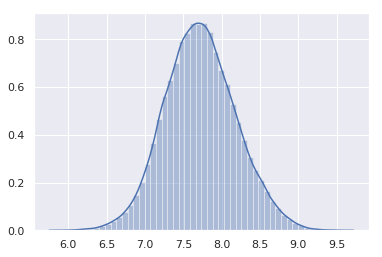

In [48]:
sns.distplot(pred)